# Multi-Strain SIR Model

This implements a simple multi-strain SIR model where there is cross immunity between strains defined by a matrix.

In [1]:
import sys
sys.path.append('../')
#sys.path.append('../tabluarepimdl')
import tabularepimdl as tepi

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

## Defining a Population

This is just like a one strain model, but with placeholders for three strains. 

In [2]:
## Population
pop_3strain = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['S','S'], categories=['S','I','R']),
        "N": np.array([990,10]),
        "T":0
    }
)


## Defining the Cross Protection Matrix and Infection Rule

We now define immunity such tht "adjacent" strains have 50% cross protection and "non-adjacent" strains have 20% cross protection. That is, cross immunity is defined by this matrix:

$$
\begin{bmatrix}
1&.5&.2\\
.5&1&.5\\
.2&.5&1
\end{bmatrix}
$$




In [3]:
##Cross protection matrix.
cp_matrix = np.array([[1.0, 0.5, 0.2],
                      [0.5, 1.0, 0.5],
                      [0.2, 0.5, 1.0]])

Use the cross-protection matrix to construct an infection rule. Assuming all strains have the same infecitous period (5 days), we are going to set this up so the strains are progressively more infectious, with $R_0$ progressing from 2.5 to 5.

In [4]:
three_strain_infect = tepi.MultiStrainInfectiousProcess(
    betas=np.array([0.5, 0.75, 1]),
    columns=["Strain1", "Strain2", "Strain3"],
    cross_protect=cp_matrix)

## Creating and Running a Deterministic Epidemic Model

Put above rules all together in a deterministic epidemic model, 
specifying the recovery times.

In [5]:
SIR_3Strain = tepi.EpiModel(pop_3strain, rules = [
    three_strain_infect,
    tepi.SimpleTransition('Strain1','I','R', 0.2),
    tepi.SimpleTransition('Strain2','I','R', 0.2),
    tepi.SimpleTransition('Strain3','I','R', 0.2)
])

Run the model. In the loop we can introduce an infected person with the appropriate characteristics on the appropriate days. In this case
day 11 and day 20.

In [6]:
intro_day1 = 11
intro_day2 = 20

for t in np.arange(0,100,0.25):
    if t == intro_day1:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['I'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['S'], categories=['S','I','R']),
            'N':1,
            'T':[t]
         })
        SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
    if t == intro_day2:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['I'], categories=['S','I','R']),
            'N':1,
            'T':[t]
         })
        SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
    SIR_3Strain.do_timestep(dt=0.25)

Plot the graph.

In [7]:
long_epi_determ = SIR_3Strain.full_epi.melt(id_vars=['N','T'], value_vars=['Strain1', 'Strain2', 'Strain3'], var_name='Strain', value_name="InfState")
long_epi_determ = long_epi_determ.groupby(["T","Strain","InfState"]).sum().reset_index()

epi_fig_determ = px.line(long_epi_determ, x="T", y="N", color="InfState", line_dash="Strain", title='3 Strains Infection Change on a Population - Deterministic')
epi_fig_determ.show()


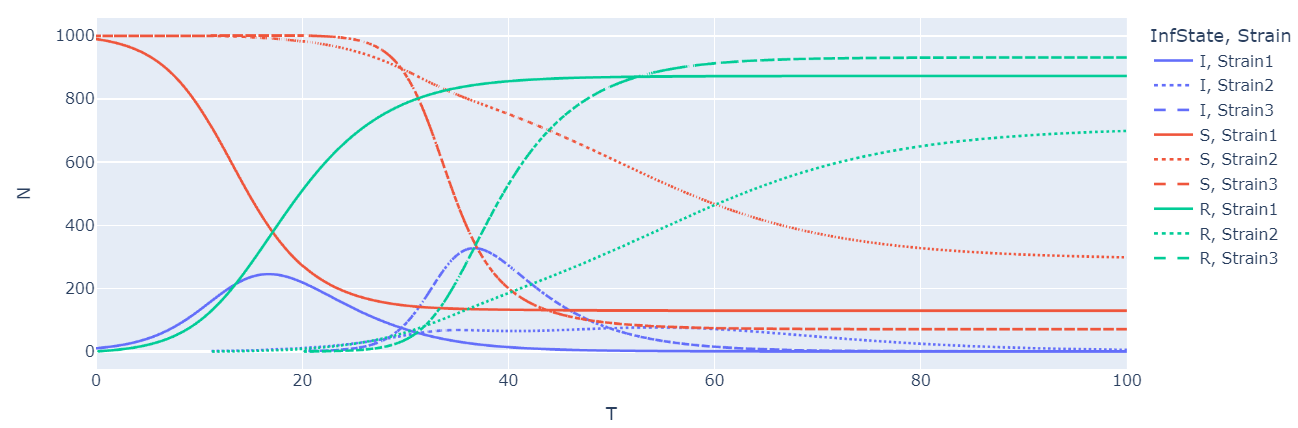

## Making a Stochastic Version

Make the model stochastic. We are going to make everything stochastic, that is to take the same model, reset it, and set the `EpiModel.stoch_policy` parameter to `"stochastic"`. We will do multiple runs where the introduction day is a random variable. 

In [8]:
SIR_3Strain.reset()
SIR_3Strain.stoch_policy="stochastic"

##go through multiple times appending the simulation. 
all_sims = pd.DataFrame() #create an empty dataframe

for sim in range(15):
    SIR_3Strain.reset()
    
    intro_day1 = np.random.poisson(10)
    intro_day2 = intro_day1 + np.random.poisson(10)
    for t in np.arange(0,100,0.25):
        if t == intro_day1:
            to_add = pd.DataFrame({
                'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
                'Strain2':pd.Categorical(['I'], categories=['S','I','R']),
                'Strain3':pd.Categorical(['S'], categories=['S','I','R']),
                'N':1,
                'T':[t]
            }) 
            SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
        if t == intro_day2:
            to_add = pd.DataFrame({
                'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
                'Strain2':pd.Categorical(['S'], categories=['S','I','R']),
                'Strain3':pd.Categorical(['I'], categories=['S','I','R']),
                'N':1,
                'T':[t]
            })
            SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
        SIR_3Strain.do_timestep(dt=0.25)

    tmp = SIR_3Strain.full_epi
    tmp['sim'] = sim
    all_sims = pd.concat([all_sims,tmp])

all_sims.reset_index(drop=True)

,Strain1,Strain2,Strain3,N,T,sim
0,S,S,S,990,0.00,0
1,I,S,S,10,0.00,0
2,I,S,S,10,0.25,0
3,R,S,S,1,0.25,0
4,S,S,S,989,0.25,0
...,...,...,...,...,...,...
53499,R,S,R,886,100.00,14
53500,R,S,S,21,100.00,14
53501,S,R,R,1,100.00,14
53502,S,S,R,93,100.00,14


Plot the graph.

In [9]:
long_epi_stoch = all_sims.melt(id_vars=['N','T','sim'], value_vars=['Strain1', 'Strain2', 'Strain3'], var_name='Strain', value_name="InfState")
long_epi_stoch = long_epi_stoch.groupby(["T","Strain","InfState","sim"]).sum().reset_index()

epi_fig_stoch = px.line(long_epi_stoch, x="T", y="N", color="InfState", line_dash="Strain", line_group="sim", title='3 Strains Infection Change on a Population - Stochastic')
epi_fig_stoch.update_traces(opacity=0.25)
epi_fig_stoch.show()

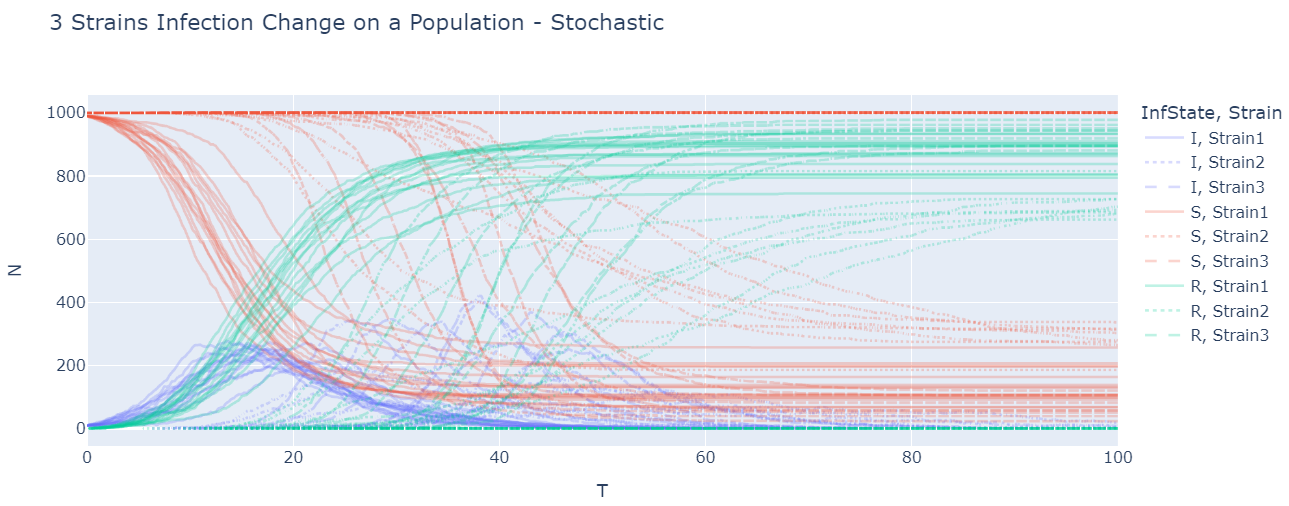

### Add Deterministic Simple Observation Rule

In [10]:
pop_3strain_hosp = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I','R'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S','I'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['I','S','S'], categories=['S','I','R']),
        "Hosp1": "U",
        "Hosp2": "U",
        "Hosp3": "U",
        "N": np.array([1000,1000,1000]),
        "T":0
    }
)
pop_3strain_hosp

,Strain1,Strain2,Strain3,Hosp1,Hosp2,Hosp3,N,T
0,S,S,I,U,U,U,1000,0
1,I,S,S,U,U,U,1000,0
2,R,I,S,U,U,U,1000,0


In [11]:
hosp_rule1 = tepi.SimpleObservationProcess(source_col="Strain1",source_state="I", obs_col="Hosp1", rate=.05, stochastic=False)
hosp_rule2 = tepi.SimpleObservationProcess(source_col="Strain2",source_state="I", obs_col="Hosp2", rate=.02, stochastic=False)
hosp_rule3 = tepi.SimpleObservationProcess(source_col="Strain3",source_state="I", obs_col="Hosp3", rate=.01, stochastic=False)

In [12]:
print(hosp_rule1.get_deltas(pop_3strain_hosp))
print(hosp_rule2.get_deltas(pop_3strain_hosp))
print(hosp_rule3.get_deltas(pop_3strain_hosp))

  Strain1 Strain2 Strain3 Hosp1 Hosp2 Hosp3          N  T
0       I       S       S     U     U     U -48.770575  0
1       I       S       S     I     U     U  48.770575  0
  Strain1 Strain2 Strain3 Hosp1 Hosp2 Hosp3          N  T
0       R       I       S     U     U     U -19.801327  0
1       R       I       S     U     I     U  19.801327  0
  Strain1 Strain2 Strain3 Hosp1 Hosp2 Hosp3         N  T
0       S       S       I     U     U     U -9.950166  0
1       S       S       I     U     U     I  9.950166  0


Add Simple Obervation rule to the epidemic model. Note that this rule need to be in a different rule group so there is not "competition" for people from various states.


In [13]:
#Create the base population, this time with only one person infected with strain 1.

pop_3strain_hosp = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Hosp1": "U",
        "Hosp2": "U",
        "Hosp3": "U",
        "N": np.array([9999,1]),
        "T":0
    }
)


# Make the epidemic model
SIR_3Strain_hosp =  tepi.EpiModel(pop_3strain_hosp, rules = [[
    three_strain_infect,
    tepi.SimpleTransition('Strain1','I','R', 0.1),
    tepi.SimpleTransition('Strain2','I','R', 0.05),
    tepi.SimpleTransition('Strain3','I','R', 0.2)],
    [hosp_rule1, hosp_rule2, hosp_rule3]
])


#Run the model
intro_day1 = 11
intro_day2 = 20

for t in np.arange(0,100,0.25):
    
    if t == intro_day1:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['I'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['S'], categories=['S','I','R']),
            'Hosp1': ['U'],
            'Hosp2': ['U'],
            'Hosp3': ['U'],
            'N':1,
            'T':[t]
         })
        SIR_3Strain_hosp.cur_state = pd.concat([SIR_3Strain_hosp.cur_state, to_add])
    if t == intro_day2:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['I'], categories=['S','I','R']),
            'Hosp1': ['U'],
            'Hosp2': ['U'],
            'Hosp3': ['U'],
            'N':1,
            'T':[t]
         })
        SIR_3Strain_hosp.cur_state = pd.concat([SIR_3Strain_hosp.cur_state, to_add])
    SIR_3Strain_hosp.do_timestep(dt=0.25)

In [14]:
SIR_3Strain_hosp.cur_state

,Strain1,Strain2,Strain3,Hosp1,Hosp2,Hosp3,N,T
0,I,R,R,I,P,P,0.001330,100.0
1,I,R,R,I,P,U,0.031937,100.0
2,I,R,R,I,U,P,0.002861,100.0
3,I,R,R,I,U,U,0.066734,100.0
4,I,R,R,P,P,P,0.045619,100.0
...,...,...,...,...,...,...,...,...
129,S,S,I,U,U,P,0.000006,100.0
130,S,S,I,U,U,U,0.000011,100.0
132,S,S,R,U,U,P,0.005350,100.0
133,S,S,R,U,U,U,0.025652,100.0


Look at the results. We can check the number of folks' different hospitalized states with each strain.

In [15]:
#after iterations, cur_state has the final number of people who get recovered from each Strain, the number of people who currently get infected by each Strain, and the number of people who are hospitalized, 
#therefore the number of overall infected people should be equal to the number of people who recovered plus the number of people who are currently infected with each Strain

res_sum_3strain = pd.DataFrame({
    'Strain': [1, 2, 3],
    'Overall_Infect': [
               SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Strain1'] == 'R']['N'].sum() + \
               SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Strain1'] == 'I']['N'].sum(), #total num of people infected with Strain1
               
               SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Strain2'] == 'R']['N'].sum() + \
               SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Strain2'] == 'I']['N'].sum(), #total num of people infected with Strain2

               SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Strain3'] == 'R']['N'].sum() + \
               SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Strain3'] == 'I']['N'].sum()  #total num of people infected with Strain3
              ],
    'Hosp_unobs': [SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp1'] == 'U']['N'].sum(), #total Hosp1 unobs with Strain1
                   SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp2'] == 'U']['N'].sum(), #total Hosp2 unobs with Strain2
                   SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp3'] == 'U']['N'].sum()  #total Hosp3 unobs with Strain3
                  ],
    'Hosp_incobs': [SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp1'] == 'I']['N'].sum(), #total Hosp1 incobs with Strain1
                    SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp2'] == 'I']['N'].sum(), #total Hosp2 incobs with Strain2
                    SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp3'] == 'I']['N'].sum()  #total Hosp3 incobs with Strain3
                   ],
    'Hosp_prevobs': [SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp1'] == 'P']['N'].sum(), #total Hosp1 prevobs with Strain1
                     SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp2'] == 'P']['N'].sum(), #total Hosp2 prevobs with Strain2
                     SIR_3Strain_hosp.cur_state[SIR_3Strain_hosp.cur_state['Hosp3'] == 'P']['N'].sum()  #total Hosp3 prevobs with Strain3
                    ]
})


res_sum_3strain

,Strain,Overall_Infect,Hosp_unobs,Hosp_incobs,Hosp_prevobs
0,1,8230.717292,7228.534071,0.170554,2773.295374
1,2,9882.981786,7213.979420,0.941932,2787.078649
2,3,7483.727142,9658.521260,1.178659,342.300082
